In [1]:
# PyTorch Setup
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("CPU is being used")


from IPython.core.magic import register_line_cell_magic
@register_line_cell_magic
def hyperparameters(hp_var_name, cell):
    with open('experiment.yaml', 'w') as f:
        f.write(cell)
    HP = omegaconf.OmegaConf.load('experiment.yaml')
    get_ipython().user_ns[hp_var_name] = HP

GPU is available


In [2]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import collections
import termcolor
import functools 
import random
import pickle
import os
import gc
import timm
import omegaconf
import wandb
import transformers
import datasets
import sklearn
import sklearn.metrics
import sklearn.model_selection

from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm

tqdm.pandas()

In [3]:
# Define the hyperparameters
args = {
    'backbone_name': 'repvit_m3',
    'img_size': 224,
    'num_train_epochs': 10,
    'train_batch_size': 8,
    'test_batch_size': 8,
    'warmup_ratio': 0.10,
    'peak_lr': 1e-6,
    'weight_decay': 1e-8,
    'max_grad_norm': 1000.00,
    'validation_split': 0.10,
}


In [4]:
# Create the model
backbone = timm.create_model(args['backbone_name'], pretrained=True)

In [5]:
df = pd.read_csv('trainLabels.csv')
img_path = 'C:\\Users\\Tirta Irawan\\Jupyter\\Kalbe Digital AI\\CV KDU - Week 2 - RepVIT\\resized_train\\resized_train\\'
df['img_path'] = img_path + df.image + '.jpeg'

train_df, valid_df = sklearn.model_selection.train_test_split(df, test_size=args['validation_split'])
train_df

,image,level,img_path
18629,23483_right,0,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
30819,38964_right,0,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
29655,37539_right,2,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
23483,29679_right,0,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
8881,11155_right,0,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
...,...,...,...
1506,1886_left,0,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
12671,15894_right,0,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
23424,29627_left,0,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...
5925,7468_right,1,C:\Users\Tirta Irawan\Jupyter\Kalbe Digital AI...


In [6]:
from dataset import DiabeticRetinopathyDataset

train_dataset = DiabeticRetinopathyDataset(train_df.img_path.values, train_df.level.values, img_size=args['img_size'])
valid_dataset = DiabeticRetinopathyDataset(valid_df.img_path.values, valid_df.level.values, img_size=args['img_size'])

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=args['train_batch_size'],
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)
valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=args['test_batch_size'],
    shuffle=False, 
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
)

batch = next(iter(valid_dataloader))

In [7]:
from dataset_repvit import DiabeticRetinopathyRepViTModel

model = DiabeticRetinopathyRepViTModel(backbone).to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4, weight_decay=1e-2)
logits = model(batch['img'].to(device))
logits.shape

torch.Size([8, 5])

In [9]:
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
loss_fn = torch.nn.BCEWithLogitsLoss()

# Create lists to store the losses
train_losses = []
valid_losses = []

for epoch in range(args['num_train_epochs']):
    epoch_metrics = collections.defaultdict(list)
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        optimizer.zero_grad()
        logits = model(batch['img'])
        loss = loss_fn(logits, batch['label'].to(torch.float))
        loss.backward()
        optimizer.step()
        
        epoch_metrics['loss'].append(loss.item())
    
    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_metrics['loss']) / len(epoch_metrics['loss'])
    train_losses.append(avg_train_loss)
    print(f"{colored('train_loss', 'blue')}: {colored(avg_train_loss, 'red')}")
            
    validation_metrics = collections.defaultdict(list)
    all_labels = []
    all_predictions = []
    for step, batch in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        logits = model(batch['img'])
        loss = loss_fn(logits, batch['label'].to(torch.float))
        validation_metrics['loss'].append(loss.item())

        # Store the true labels and the model's predictions
        predictions = torch.argmax(logits, dim=1)
        all_labels.extend(batch['label'].cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

    # Calculate average validation loss for the epoch
    avg_valid_loss = sum(validation_metrics['loss']) / len(validation_metrics['loss'])
    valid_losses.append(avg_valid_loss)
    print(f"validation {colored('loss', 'blue')}: {colored(avg_valid_loss, 'red')}")

    # Calculate performance metrics
    all_labels = np.argmax(all_labels, axis=1)  # Add this line
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    print(f"validation {colored('accuracy', 'blue')}: {colored(accuracy, 'red')}")
    print(f"validation {colored('precision', 'blue')}: {colored(precision, 'red')}")
    print(f"validation {colored('recall', 'blue')}: {colored(recall, 'red')}")
    print(f"validation {colored('f1 score', 'blue')}: {colored(f1, 'red')}")

  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.2322719989953102


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.22673508574112672
validation accuracy: 0.7895785876993167
validation precision: 0.7591730609952504
validation recall: 0.379872070874134
validation f1 score: 0.40683545700256224


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.20831049625438638


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.21945649672274167
validation accuracy: 0.7947038724373576
validation precision: 0.6120162574666916
validation recall: 0.4378042448143823
validation f1 score: 0.4759904862127101


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.18117022443722092


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.23075359930753164
validation accuracy: 0.7955580865603644
validation precision: 0.5529195464309039
validation recall: 0.46160474190111705
validation f1 score: 0.49218046414837885


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.1424853633099215


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.2563124041758257
validation accuracy: 0.791002277904328
validation precision: 0.5737866167762673
validation recall: 0.4576160135880281
validation f1 score: 0.49839616972488654


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.09931136177493516


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.301645989179747
validation accuracy: 0.7687927107061503
validation precision: 0.5415685272287594
validation recall: 0.4585721258100877
validation f1 score: 0.48312124536256273


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.07242392586729549


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.3534827595343283
validation accuracy: 0.7702164009111617
validation precision: 0.5879631057434576
validation recall: 0.4396119289776566
validation f1 score: 0.490244999408214


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.05481799379279528


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.40250566125219445
validation accuracy: 0.780751708428246
validation precision: 0.5463497600329522
validation recall: 0.4516559507863732
validation f1 score: 0.48413052805028284


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.04692054281260908


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.4298385624537257
validation accuracy: 0.7887243735763098
validation precision: 0.5517245491027867
validation recall: 0.46415188516569533
validation f1 score: 0.4937008602554764


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.04201120575112517


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.4744170540394813
validation accuracy: 0.7844533029612756
validation precision: 0.5370460295126983
validation recall: 0.4410715752358884
validation f1 score: 0.47318796264445695


  0%|          | 0/3951 [00:00<?, ?it/s]

train_loss: 0.03848602477885149


  0%|          | 0/439 [00:00<?, ?it/s]

validation loss: 0.4499192281540246
validation accuracy: 0.7818906605922551
validation precision: 0.54450075998651
validation recall: 0.4327810284729309
validation f1 score: 0.47155892010669137


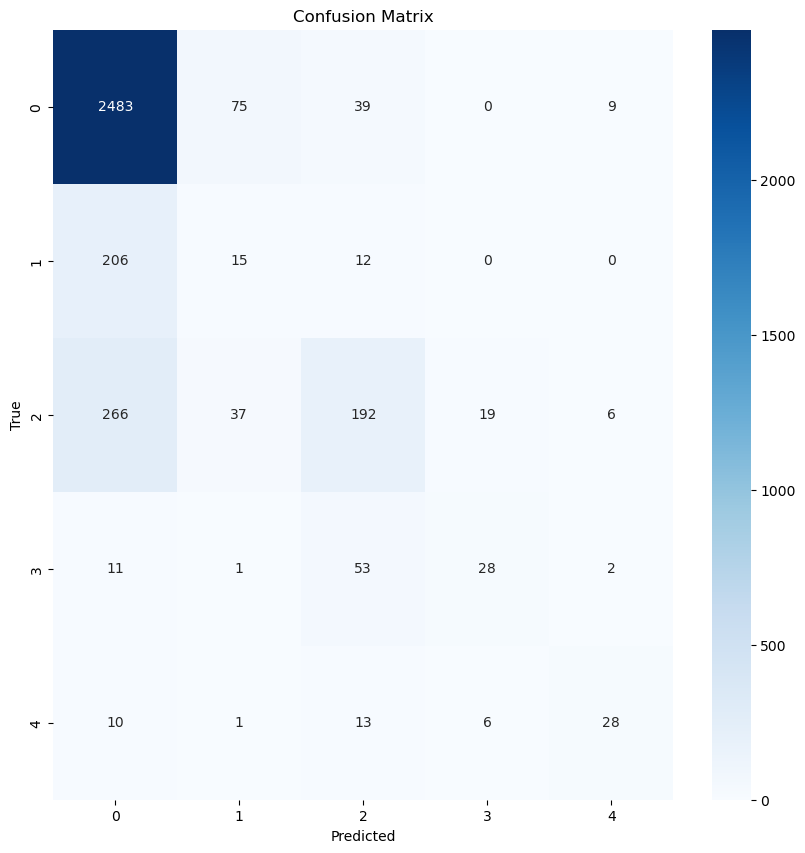

              precision    recall  f1-score   support

     Class 0       0.83      0.95      0.89      2606
     Class 1       0.12      0.06      0.08       233
     Class 2       0.62      0.37      0.46       520
     Class 3       0.53      0.29      0.38        95
     Class 4       0.62      0.48      0.54        58

    accuracy                           0.78      3512
   macro avg       0.54      0.43      0.47      3512
weighted avg       0.74      0.78      0.75      3512



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the classification report
report = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
print(report)

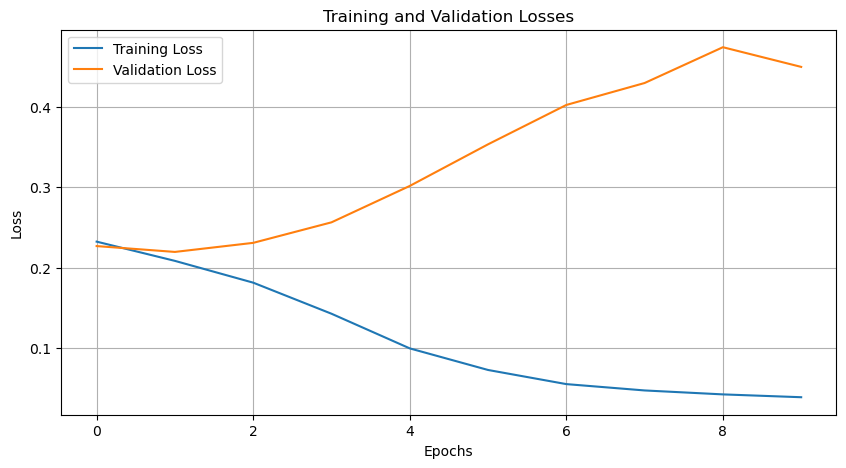

In [11]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()